In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/data science/data/18N_283.2E.csv')
df2 = pd.read_csv('/content/drive/MyDrive/data science/data/17.36N_78.5E.csv')

In [ ]:
column_names = ['year', 'month', 'day', 'hour', 'temperature', 'precipitation', 'u_wind', 'v_wind']
df1.columns = column_names
df2.columns = column_names

In [ ]:
X2 = df2.drop(columns = ['temperature'])
Y2 = df2.loc[:, ['temperature']]
X1 = df1.drop(columns = ['temperature'])
Y1 = df1.loc[:, ['temperature']]
X1 = pd.DataFrame(MinMaxScaler().fit_transform(X1), columns=X1.columns)
X2 = pd.DataFrame(MinMaxScaler().fit_transform(X2), columns=X2.columns)

In [ ]:
# def predict(model, X_train, Y_train, X_test, Y_test):
#     predictions = model.fit(X_train, Y_train).predict(X_test)
#     print(np.sqrt(mean_squared_error(predictions, Y_test)))
#     return predictions

In [ ]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [ ]:
# sns.histplot(data=np.abs(np.squeeze(np.array(Y_test), axis=1) - pred), bins=8)

In [ ]:
# models = [XGBRegressor()] #[LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(n_estimators=10), XGBRegressor()]


100%|██████████| 50/50 [01:31<00:00,  1.83s/trial, best loss: 0.48547751148414287]


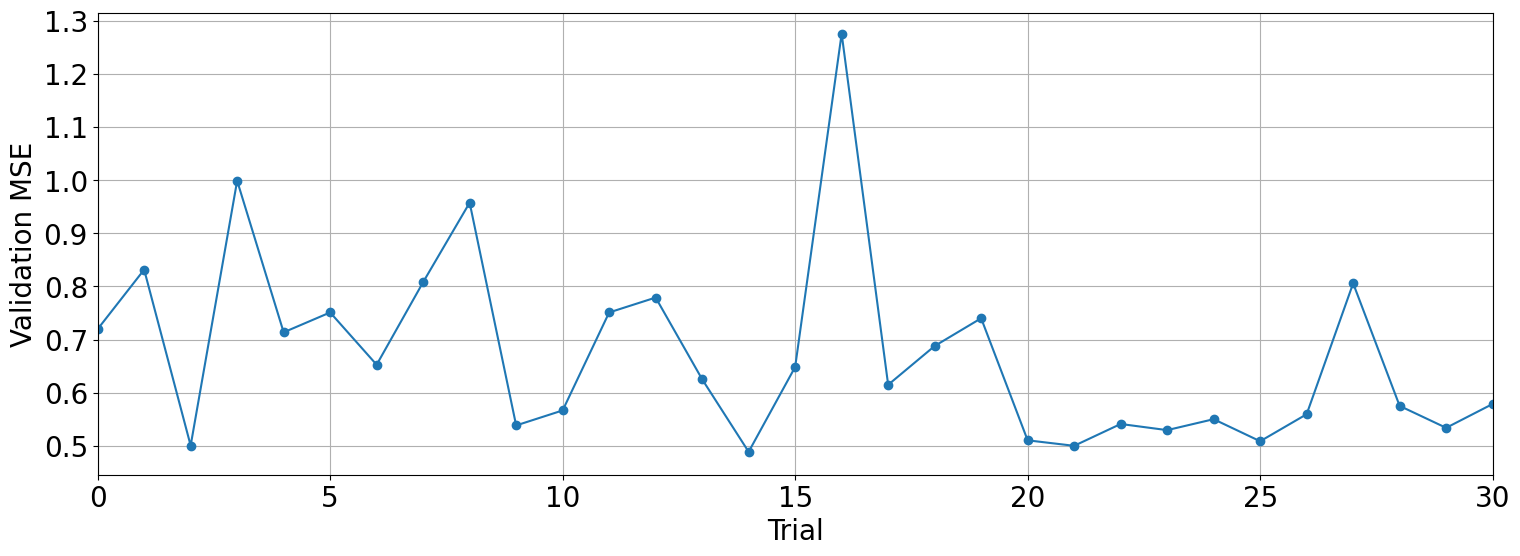

Best Hyperparameters:
{'alpha': 0.949150279334921, 'gamma': 0.5386122237105064, 'lambda': 0.4280751119883677, 'learning_rate': 0.38480831402229765, 'max_depth': 1, 'min_child_weight': 8.0, 'n_estimators': 2, 'subsample': 0.6052830252161628}


In [ ]:
space = {
    'max_depth': hp.choice('max_depth', range(2, 8)),
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    # 'colsample_bytree': hp.uniform('colsample_bytree', 1, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'alpha': hp.uniform('alpha', 0, 1),
    'lambda': hp.uniform('lambda', 0, 1),
    'learning_rate': hp.loguniform('learning_rate', -1, 0)
}

# objective function
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['objective'] = 'reg:squarederror'
    params['n_estimators'] = int(params['n_estimators'])
    params['n_jobs'] = -1
    params['random_state'] = 42

    model = xgb.XGBRegressor(**params)


    split_point = int(0.7 * len(X1))
    X_train, X_test = X1[:split_point], X1[split_point:]
    y_train, y_test = Y1[:split_point], Y1[split_point:]


    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return {'loss': mse, 'status': STATUS_OK}


max_evals = 50

# hyperparameter optimisation
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials)


losses = [trial['result']['loss'] for trial in trials.trials]

fig = plt.figure(figsize=(18, 6))
plt.plot(losses, marker='o')
plt.xlabel('Trial', fontsize=20)
plt.ylabel('Validation MSE', fontsize=20)
plt.xlim(0, 30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

print("Best Hyperparameters:")
print(best)

In [ ]:
models = [XGBRegressor(alpha=0.949150279334921, gamma=0.5386122237105064, reg_lambda=0.4280751119883677, learning_rate=0.38480831402229765, max_depth=1, min_child_weight=8.0, n_estimators=2, subsample=0.6052830252161628)]
rmses = []
for model in models:
  m = model.fit(X1, Y1)
  preds = m.predict(X2)
  rmses.append(np.sqrt(mean_squared_error(Y2, preds)))
print(rmses)

[5.766296296859138]


In [ ]:
# sns.histplot(data=np.abs(np.squeeze(np.array(Y2), axis=1) - preds), bins=20, stat='density')

In [ ]:
# # K-fold cross-validation
# # =======================
# k = 5
# kfold = KFold(n_splits=k, shuffle=True, random_state=42)
# mse_scores = [[], [], [], []]

# # Loop through each fold
# for train_index, test_index in kfold.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
#     for i in range(len(models)):
#         model = models[i]
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         mse = mean_squared_error(y_test, y_pred)
#         mse_scores[i].append(mse)

# mean_rmse = np.mean(np.sqrt(mse_scores))
# print(f"Mean RMSE across {k} folds: {mean_rmse:.4f}")

In [ ]:
# print(np.mean(mean_rmse[0]), np.mean(mean_rmse[1]), np.mean(mean_rmse[2]), np.mean(mean_rmse[3]))